In [1]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import wave
from scipy.io import wavfile
import contextlib
import os
import matplotlib.pyplot as plt

def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.frombuffer(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels

def get_start_end_frames(nFrames, sampleRate, tStart=None, tEnd=None):

    if tStart and tStart*sampleRate<nFrames:
        start = tStart*sampleRate
    else:
        start = 0

    if tEnd and tEnd*sampleRate<nFrames and tEnd*sampleRate>start:
        end = tEnd*sampleRate
    else:
        end = nFrames

    return (start,end,end-start)

def extract_audio(fname, tStart=None, tEnd=None):
    with contextlib.closing(wave.open(fname,'rb')) as spf:
        sampleRate = spf.getframerate()
        ampWidth = spf.getsampwidth()
        nChannels = spf.getnchannels()
        nFrames = spf.getnframes()

        startFrame, endFrame, segFrames = get_start_end_frames(nFrames, sampleRate, tStart, tEnd)

        # Extract Raw Audio from multi-channel Wav File
        spf.setpos(startFrame)
        sig = spf.readframes(segFrames)
        spf.close()

        channels = interpret_wav(sig, segFrames, nChannels, ampWidth, True)

        return (channels, nChannels, sampleRate, ampWidth, nFrames)

def convert_to_mono(channels, nChannels, outputType):
    if nChannels == 2:
        samples = np.mean(np.array([channels[0], channels[1]]), axis=0)  # Convert to mono
    else:
        samples = channels[0]

    return samples.astype(outputType)




In [2]:
home_path = '/Volumes/RENATA_X/Vallentinlab'
birdfolder = 'bird7159'
channel = 'chan0'
dayinuse = np.loadtxt(os.path.join(home_path,birdfolder+'_sorted','dayinuse.txt'),delimiter=',')

In [4]:
def num_target(file, time_range):
    df = pd.read_csv(file)
    return len(df.loc[df['stop_seconds']<time_range])

In [5]:
#dayinuse = np.loadtxt('../bird7159_sorted/chan6/dayinuse.txt')
call_nums = [num_target(os.path.join(home_path,birdfolder+'_sorted','chan0/dph%03d_filter_denoised_annotations.csv'%day),180) for day in dayinuse]
syl_nums = [len(pd.read_csv(os.path.join(home_path,birdfolder+'_sorted','chan6/dph%03d_filtered_denoised_sampled_annotations.csv'%day))) for day in dayinuse]

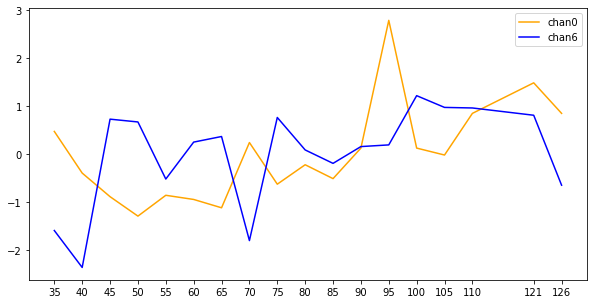

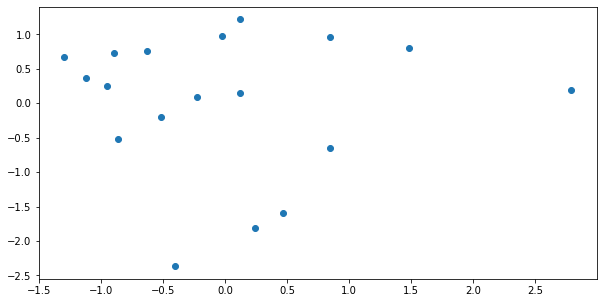

In [14]:
plt.figure(figsize=(10,5))
plt.plot(dayinuse,(np.array(call_nums)-np.mean(call_nums))/np.std(call_nums),c='orange',label='chan0')
plt.plot(dayinuse,(np.array(syl_nums)-np.mean(syl_nums))/np.std(syl_nums),c='blue',label='chan6')
plt.xticks(dayinuse)
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.scatter((np.array(call_nums)-np.mean(call_nums))/np.std(call_nums),(np.array(syl_nums)-np.mean(syl_nums))/np.std(syl_nums))
plt.show()

In [19]:
def get_syl_related_call(chan0_csv, chan6_csv):
    df_chan0 = pd.read_csv(chan0_csv)
    df_chan6 = pd.read_csv(chan6_csv)
    start_seconds = (df_chan6.loc[df_chan6.name==4].start_seconds).values
    stop_seconds = (df_chan6.loc[df_chan6.name==4].stop_seconds).values
    start_interval = np.zeros((len(df_chan0.start_seconds.values),len(start_seconds)))
    stop_interval = np.zeros((len(df_chan0.stop_seconds.values),len(stop_seconds)))
    for syl_index in range(len(start_seconds)):
        start_interval[:,syl_index] = start_seconds[syl_index] - df_chan0.start_seconds.values ## for each syl, syl start-cal start
        stop_interval[:,syl_index] = stop_seconds[syl_index] - df_chan0.stop_seconds.values 
    call_before_syl = len(np.where((start_interval>0)&(start_interval<1))[0]) # syl starts 0-1 second after cal
    call_after_syl = len(np.where((stop_interval<0)&(stop_interval>-1))[0]) # syl ends 0-1 second before cal
    call_during_syl = len(np.where((stop_interval>0)&(start_interval<0))[0])# 
    return call_before_syl,call_after_syl,call_during_syl

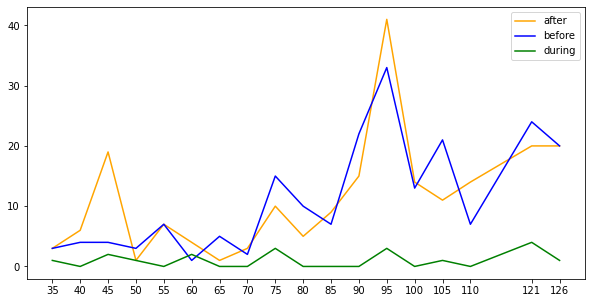

In [20]:
call_before_syls = []
call_after_syls = []
call_during_syls = []
for day in dayinuse:
    chan0_csv = os.path.join(home_path,birdfolder+'_sorted','chan0/dph%03d_filter_denoised_annotations.csv'%day)
    chan6_csv = os.path.join(home_path,birdfolder+'_sorted','chan6/dph%03d_filtered_denoised_sampled_annotations.csv'%day)
    call_before_syl, call_after_syl,call_during_syl = get_syl_related_call(chan0_csv,chan6_csv)
    call_after_syls.append(call_after_syl)
    call_before_syls.append(call_before_syl)
    call_during_syls.append(call_during_syl)
plt.figure(figsize=(10,5))
plt.plot(dayinuse,np.array(call_after_syls),c='orange',label='after')
plt.plot(dayinuse,np.array(call_before_syls),c='blue',label='before')
plt.plot(dayinuse,np.array(call_during_syls),c='green',label='during')

plt.xticks(dayinuse)
plt.legend()
plt.show()